# Synthetic Control Library Usage Example

This notebook demonstrates basic examples of using the library for synthetic control analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from synthetic_control import ClassicSyntheticControl, SyntheticDIDModel, plot_model_results, plot_cumulative_effect

## Loading Data on Cigarette Consumption in California

In [2]:
df_long = pd.read_csv('../data/california_smoking.csv')
df_long.head()

,state,cigarettes,unit,treated,year,after_treatment
0,Alabama,89.800003,0,False,1970,False
1,Alabama,95.400002,0,False,1971,False
2,Alabama,101.099998,0,False,1972,False
3,Alabama,102.900002,0,False,1973,False
4,Alabama,108.199997,0,False,1974,False


## Classic Synthetic Control

In [3]:
sc = ClassicSyntheticControl(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    unit_id='state',
    treated='treated',
    after_treatment='after_treatment',
    seed=0
)

print(f"Automatically determined treatment date: {sc.treatment_date}")

sc.fit()

sc_predictions = sc.predict()
print(f"Predictions shape: {sc_predictions.shape}")

sc_effect = sc.estimate_effect()
print(f"Effect (ClassicSyntheticControl): {sc_effect['att']:.4f}")

bootstrap_results = sc.bootstrap_effect()
print(f"Стандартная ошибка: {bootstrap_results['se']:.2f}")
print(f"95% доверительный интервал: [{bootstrap_results['ci_lower']:.2f}, {bootstrap_results['ci_upper']:.2f}]")

Automatically determined treatment date: 1989
Predictions shape: (31,)
Effect (ClassicSyntheticControl): -19.5136
Стандартная ошибка: 10.67
95% доверительный интервал: [-40.43, 1.41]


## Synthetic DID Model

In [4]:
sdid_model = SyntheticDIDModel(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    unit_id='state',
    treated='treated',
    after_treatment='after_treatment',
    seed=0
)

print(f"Automatically determined treatment date: {sdid_model.treatment_date}")

sdid_model.fit()

sdid_predictions = sdid_model.predict()
print(f"Predictions shape: {sdid_predictions.shape}")

sdid_effect = sdid_model.estimate_effect()
print(f"Effect (SyntheticDIDModel): {sdid_effect['att']:.4f}")

bootstrap_results = sdid_model.bootstrap_effect()
print(f"Стандартная ошибка: {bootstrap_results['se']:.4f}")
print(f"95% доверительный интервал: [{bootstrap_results['ci_lower']:.4f}, {bootstrap_results['ci_upper']:.4f}]")

Automatically determined treatment date: 1989
Predictions shape: (31,)
Effect (SyntheticDIDModel): -15.6051
Стандартная ошибка: 8.8115
95% доверительный интервал: [-32.8753, 1.6651]


## Visualization of Results for Both Models

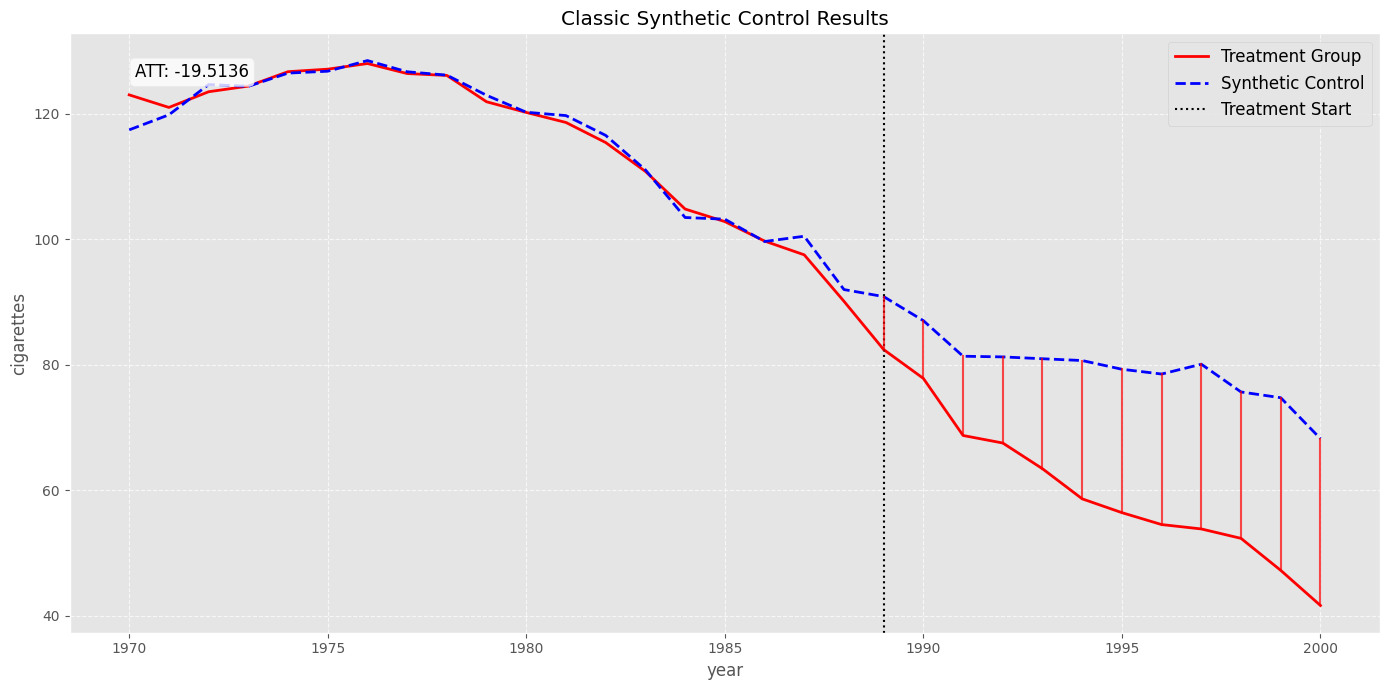

In [5]:
fig_classic = plot_model_results(
    model=sc, 
    figsize=(14, 7),
    show=False
)
plt.title('Classic Synthetic Control Results')
plt.show()

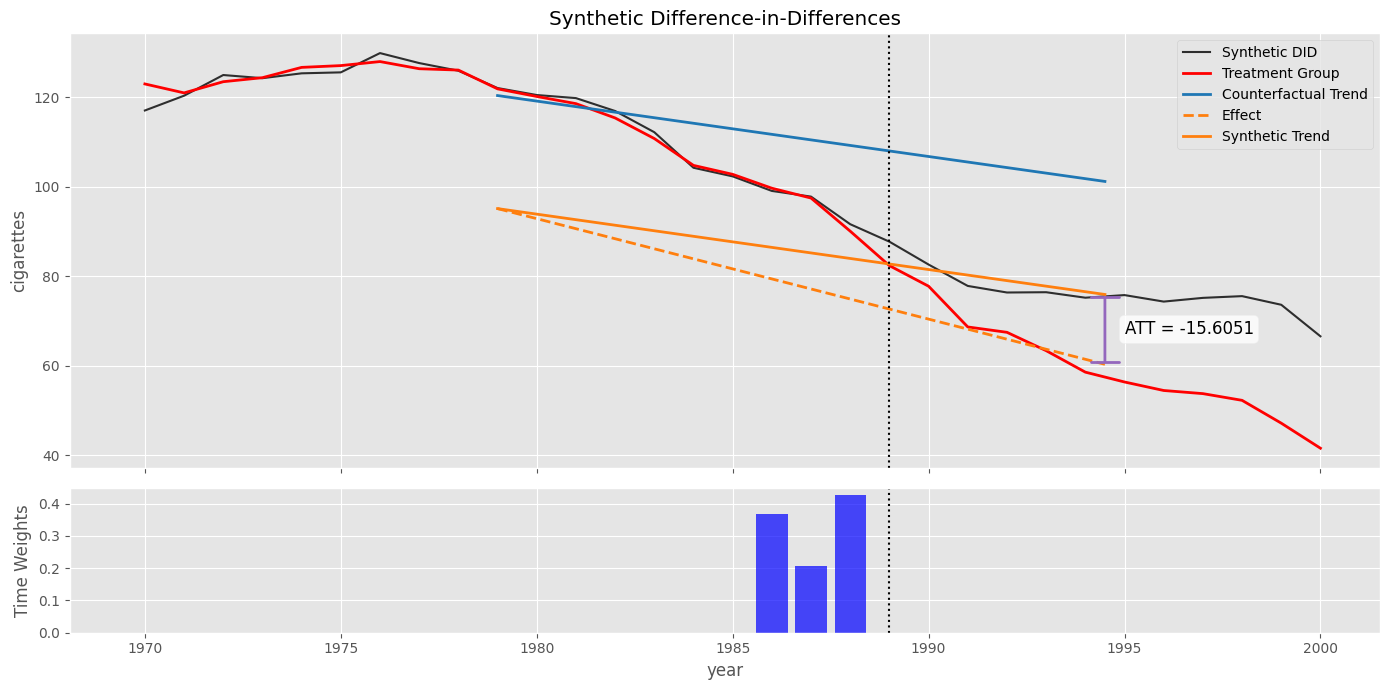

In [6]:
fig_sdid = plot_model_results(
    model=sdid_model, 
    figsize=(14, 7),
    show=False
)


## Cumulative Effect Visualization

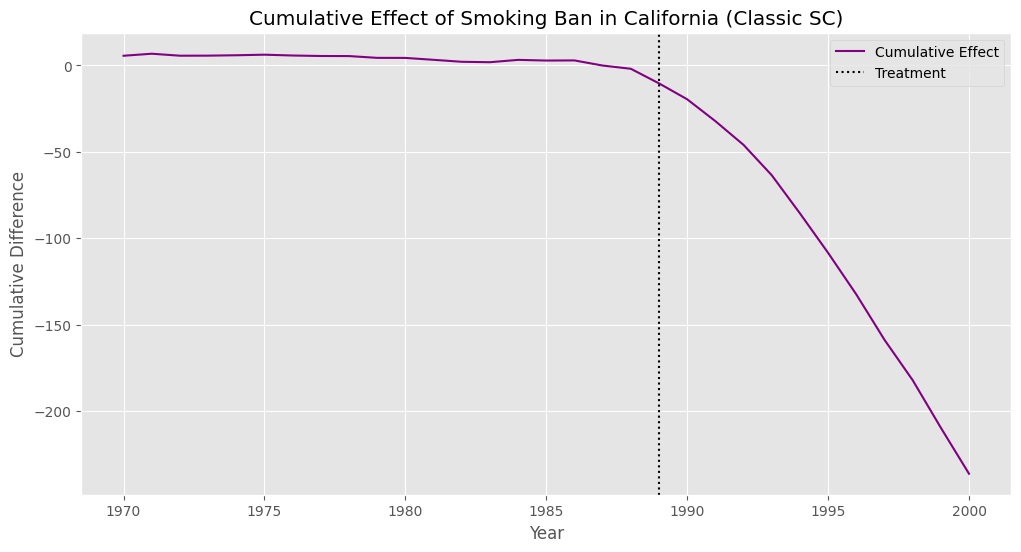

In [7]:
fig_cumulative_sc = plot_cumulative_effect(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    treated='treated',
    predictions=sc_predictions,
    treatment_date=sc.treatment_date,  
    title='Cumulative Effect of Smoking Ban in California (Classic SC)',
    xlabel='Year',
    ylabel='Cumulative Difference'
)
plt.show()

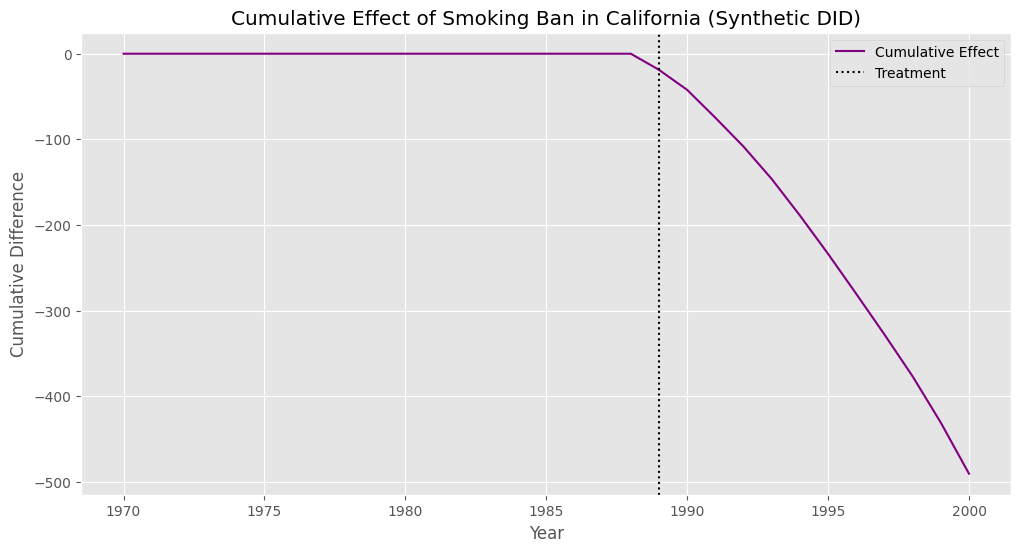

In [8]:
fig_cumulative_sdid = plot_cumulative_effect(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    treated='treated',
    predictions=sdid_predictions,
    treatment_date=sdid_model.treatment_date,  
    title='Cumulative Effect of Smoking Ban in California (Synthetic DID)',
    xlabel='Year',
    ylabel='Cumulative Difference'
)
plt.show()

## Weights comparison

In [9]:
weights = pd.read_csv('../data/unit_estimates.csv')

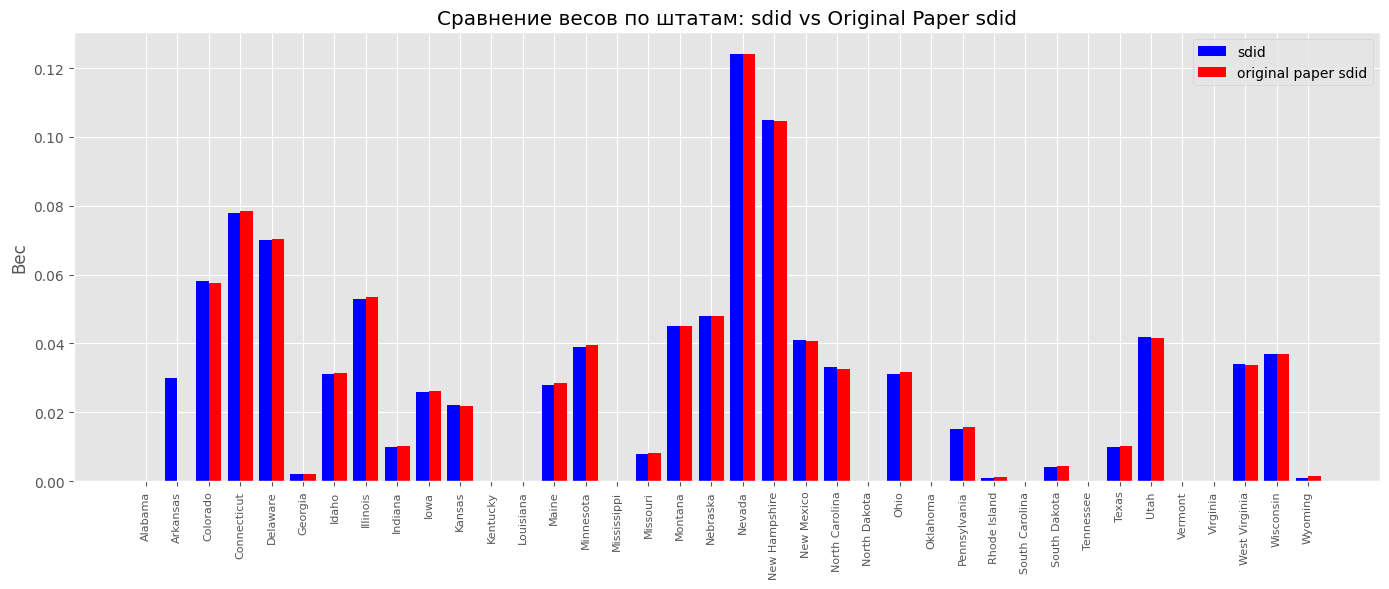

In [10]:
df_plot = weights.set_index('state')[['unit_weight_sdid']].copy()
df_plot['original_sdid'] = sdid_effect['weights']
df_plot = df_plot.reset_index()

states = df_plot['state']
x = list(range(len(states)))
width = 0.4

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar([i - width/2 for i in x],
       df_plot['unit_weight_sdid'],
       width=width,
       label='sdid',
       color='blue')

ax.bar([i + width/2 for i in x],
       df_plot['original_sdid'],
       width=width,
       label='original paper sdid',
       color='red')

ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90, fontsize=8)
ax.set_ylabel('Вес')
ax.set_title('Сравнение весов по штатам: sdid vs Original Paper sdid')
ax.legend()

plt.tight_layout()
plt.show()
